In [1]:
from dataloaders import data_set,data_dict
import torch
import yaml
import os
import torch.nn as nn

import torch
import torch.optim as optim

from dataloaders import data_set,data_dict
from models.model_builder import model_builder


import numpy as np

import ray
from ray import tune, air
from ray.air import session, Checkpoint
from ray.tune.examples.mnist_pytorch import ConvNet, get_data_loaders, train, test
from ray.tune.schedulers import PopulationBasedTraining

from functionapi import train_net
from PBTTrainable import RayModel

from analysis import plot_hp_history, get_average_frame, _load_policy, get_best_frame
import random

import matplotlib.pyplot as plt
from utils import adjust_learning_rate_class
from ray.tune.schedulers.pb2 import PB2

from pbtexperiment import validation, _get_data

/home/janis/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-23 15:37:54,135	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-08-23 15:37:54,183	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-08-23 15:37:54,256	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


2023-08-23 15:37:56,577	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2023-08-23 15:37:56,600	ERROR checkpoint_manager.py:188 -- The requested checkpoint is not available on this node, most likely because you are using Ray client or disabled checkpoint synchronization. To avoid this, enable checkpoint synchronization to cloud storage by specifying a `SyncConfig`. The checkpoint may be available on a different  node - please check this location on worker nodes: /home/janis/PopulationBasedTraining/RayTuneResults/dg/pbt/03/train_net_2401c_00015_15_2023-08-22_16-49-48/checkpoint_000059
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with n

/home/janis/PopulationBasedTraining/RayTuneResults/dg/pbt/run4/results/start1/03/train_net_2401c_00000_0_2023-08-22_16-49-48


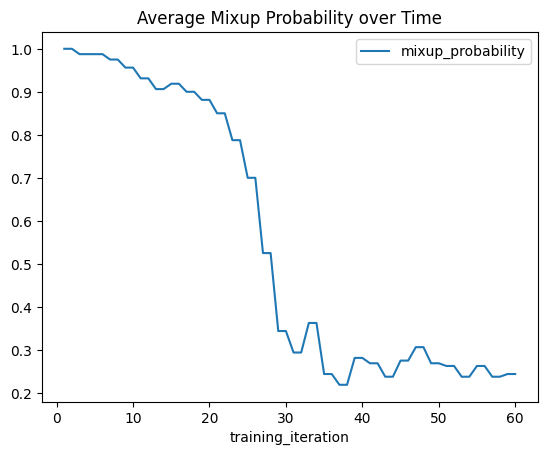

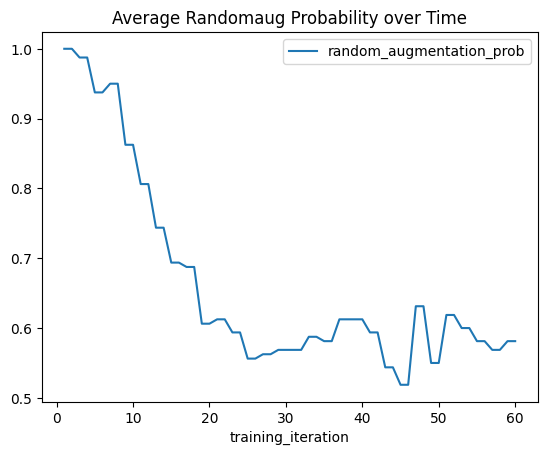

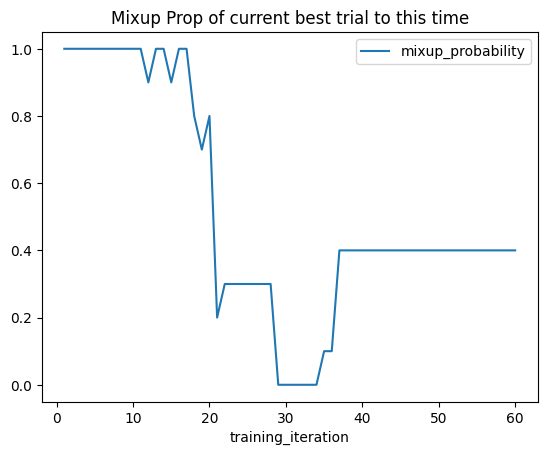

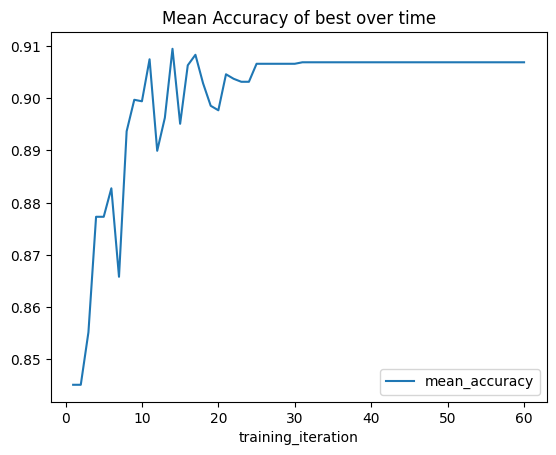

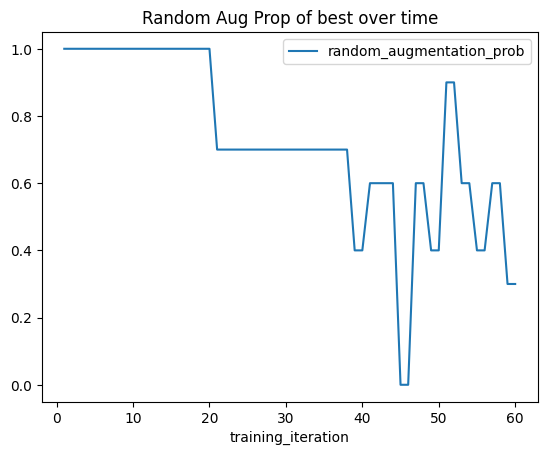

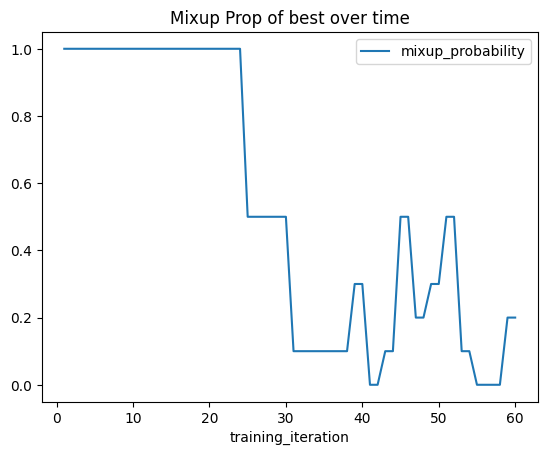

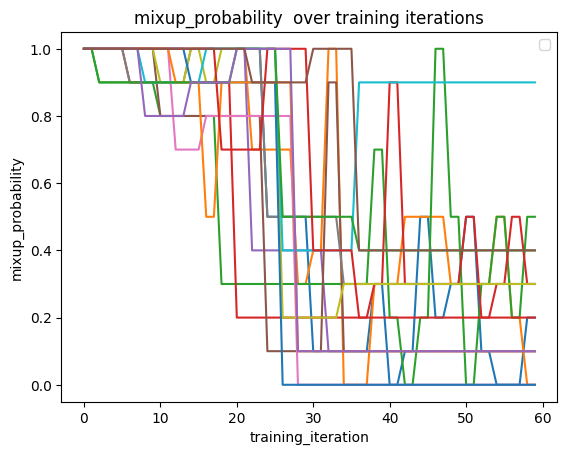

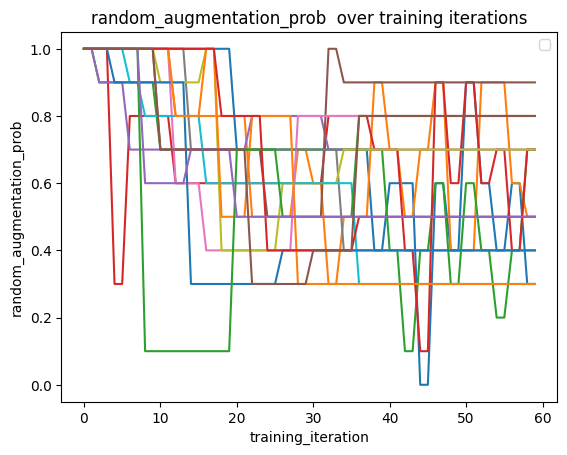

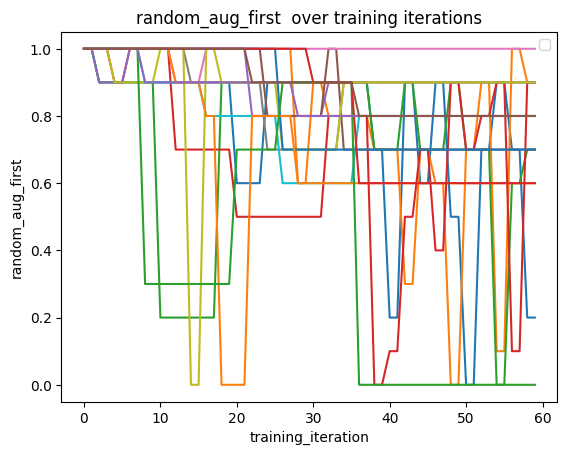

In [2]:
experiment_path = "/home/janis/PopulationBasedTraining/RayTuneResults/dg/pbt/run4/results/start1/03"

#trainable = RayModel
trainable = train_net

restored_tuner = tune.Tuner.restore(experiment_path,trainable=trainable)
results_grid = restored_tuner.get_results()
best_result = results_grid.get_best_result(mode="max", metric="mean_accuracy")

print(best_result._local_path)

max_data_frame = get_best_frame(results_grid)

get_average_frame(results_grid, "mixup_probability").plot(title="Average Mixup Probability over Time")
get_average_frame(results_grid, "random_augmentation_prob").plot(title="Average Randomaug Probability over Time")

max_data_frame.plot('training_iteration', 'mixup_probability', title="Mixup Prop of current best trial to this time")
best_result.metrics_dataframe.plot("training_iteration", "mean_accuracy", title="Mean Accuracy of best over time")
best_result.metrics_dataframe.plot("training_iteration", "random_augmentation_prob", title="Random Aug Prop of best over time")
best_result.metrics_dataframe.plot("training_iteration", "mixup_probability", title="Mixup Prop of best over time")


#results_grid[10].metrics_dataframe.plot("training_iteration", "mean_accuracy")
#results_grid[10].metrics_dataframe.plot("training_iteration", "mixup_probability")

plot_hp_history(results_grid, "mixup_probability")
plot_hp_history(results_grid, "random_augmentation_prob")
plot_hp_history(results_grid, "random_aug_first")

#best_result.metrics_dataframe

#best_checkpoint = best_result.checkpoint
#checkpoint_dict = best_checkpoint.to_dict()

Schedule of trial

{'random_augmentation_prob': 1, 'mixup_probability': 1, 'random_aug_first': 1, 'checkpoint_interval': 1}


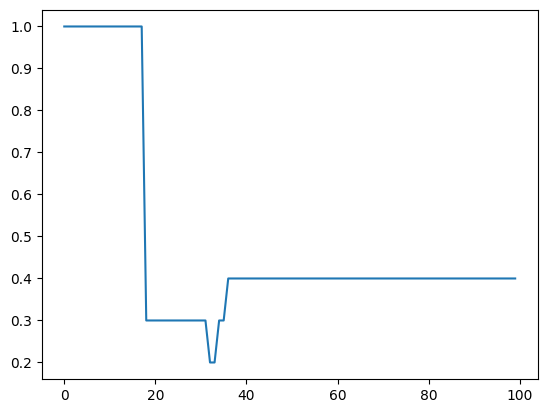

In [35]:
path = "/home/janis/PopulationBasedTraining/RayTuneResults/dg/pbt/run4/results/start1/03/pbt_policy_2401c_00012.txt"
epochs = 100
parameter = "mixup_probability"

config, policy = _load_policy(path)
print(config)
x = []
y = []

for i in range(epochs):
    if (len(policy) > 0):
        it, po = policy[0]
        if i == it:
            policy.pop(0)
            config = po
    
    x.append(i)
    y.append(config[parameter])
    
plt.plot(x, y)
plt.show()




Compare Multiple runs

2023-08-23 14:43:05,323	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2023-08-23 14:43:05,343	ERROR checkpoint_manager.py:188 -- The requested checkpoint is not available on this node, most likely because you are using Ray client or disabled checkpoint synchronization. To avoid this, enable checkpoint synchronization to cloud storage by specifying a `SyncConfig`. The checkpoint may be available on a different  node - please check this location on worker nodes: /home/janis/PopulationBasedTraining/RayTuneResults/dg/pbt/05/train_net_39625_00006_6_2023-08-22_20-46-37/checkpoint_000059
2023-08-23 14:43:05,366	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most like

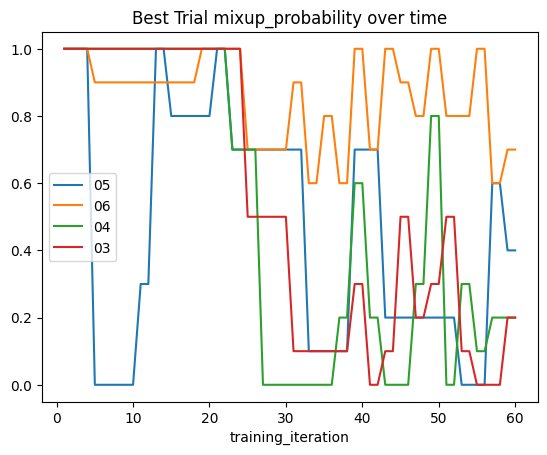

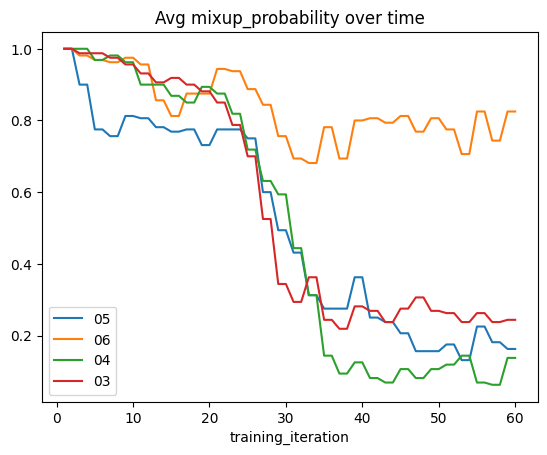

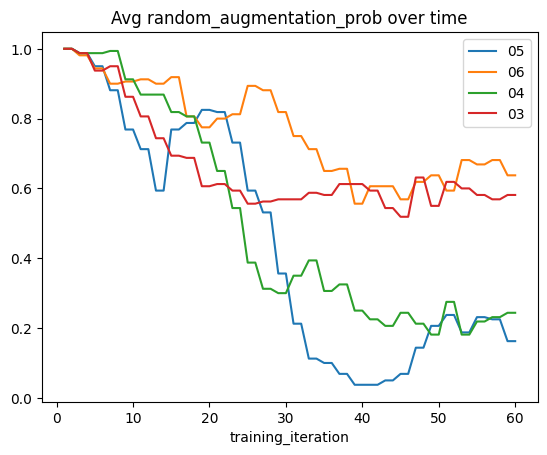

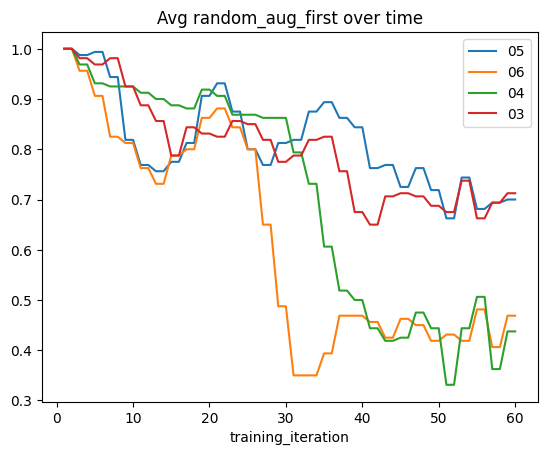

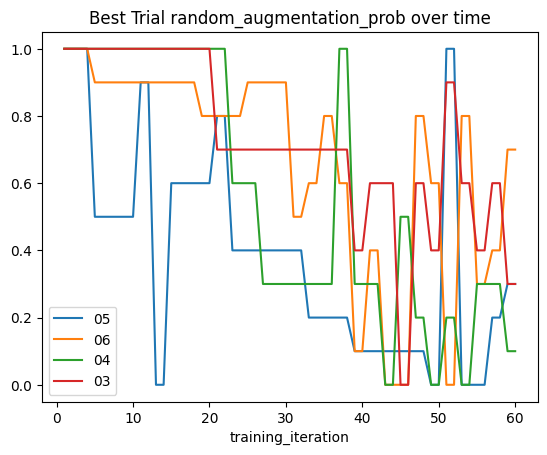

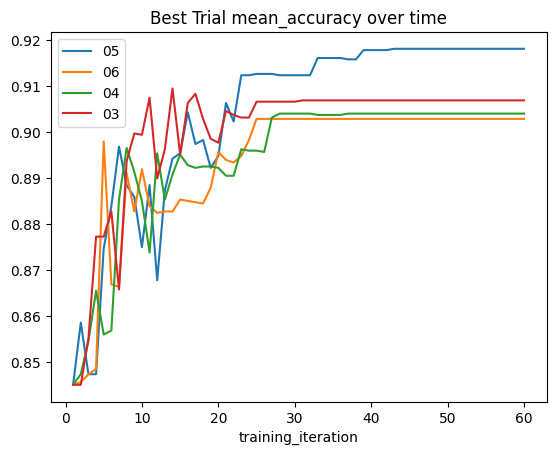

In [6]:
experiment_folder = "/home/janis/PopulationBasedTraining/RayTuneResults/dg/pbt/run5"

#trainable = RayModel
trainable = train_net

def compare_experiments(experiment_folder, trial, parameter):
    ax=None
    
    legend = []

    for f in os.listdir(experiment_folder):
        legend.append(f)
        restored_tuner = tune.Tuner.restore(experiment_folder+"/"+f,trainable=trainable)
        grid = restored_tuner.get_results()
        
        if trial == "avg":
            frame = get_average_frame(grid, parameter)
            ax = frame.plot(ax=ax, title="Avg " + parameter + " over time")
        elif trial == "best":
            frame = grid.get_best_result(mode="max", metric="mean_accuracy").metrics_dataframe[["training_iteration", parameter]]
            ax = frame.plot(ax=ax, x="training_iteration",y=parameter, title="Best Trial " + parameter + " over time")
    
    ax.legend(legend)
    
    

        
compare_experiments(experiment_folder, "best", "mixup_probability")

compare_experiments(experiment_folder, "avg", "mixup_probability")

compare_experiments(experiment_folder, "avg", "random_augmentation_prob")

compare_experiments(experiment_folder, "avg", "random_aug_first")

compare_experiments(experiment_folder, "best", "random_augmentation_prob")

compare_experiments(experiment_folder, "best", "mean_accuracy")


In [ ]:
experiment_folder = "/home/janis/PopulationBasedTraining/RayTuneResults/hapt/pbt"

for f in os.listdir(experiment_folder):
    restored_tuner = tune.Tuner.restore(experiment_folder+"/"+f,trainable=pb.train_net)
    grid = restored_tuner.get_results()
    best = grid.get_best_result(mode="max", metric="mean_accuracy")
    print("Best Trial Mean Accuracy: {}, iterations: {}, mixup Propability: {}, Random Aug Propability: {}".
          format(best.metrics["mean_accuracy"], best.metrics["training_iteration"], 
                 best.metrics["mixup_probability"], best.metrics["random_augmentation_prob"]))

2023-08-14 17:14:35,991	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2023-08-14 17:14:36,020	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is periodic.
2023-08-14 17:14:36,049	INFO experiment_analysis.py:972 -- No trial data passed in during `ExperimentAnalysis` initialization -- you are most likely loading the experiment after it has completed.
Loading trial data from the experiment checkpoint file. This may result in loading some stale information, since checkpointing is pe

Best Trial Mean Accuracy: 0.9413184492381959, iterations: 100, mixup Propability: 0.0, Random Aug Propability: 1.0
Best Trial Mean Accuracy: 0.9321164579876301, iterations: 55, mixup Propability: 0.7000000000000001, Random Aug Propability: 0.4
Best Trial Mean Accuracy: 0.921255091265651, iterations: 18, mixup Propability: 0.4, Random Aug Propability: 0.4
Best Trial Mean Accuracy: 0.9413184492381959, iterations: 100, mixup Propability: 0.2, Random Aug Propability: 0.30000000000000004


average test results of runs

In [29]:
experiment_folder = "/home/janis/PopulationBasedTraining/RayTuneResults/dg/pbt/run4/results/start1"

lines = []

for dir in os.listdir(experiment_folder):
    path = experiment_folder+'/' + dir + '/best_trial_final_test_results.txt'
    if (os.path.exists(path)):
        f = open(path)
        lines.append(f.readline())
        f.close()
        
total_losses = []
accuracies = []
f_w = []
f_macro = []

for line in lines:
    total_losses.append(float(line.split(' ')[5]))
    accuracies.append(float(line.split(' ')[7]))
    f_w.append(float(line.split(' ')[10]))
    f_macro.append(float(line.split(' ')[12]))
    

print('runs ' + str(len(total_losses)))
print('average total loss ' + str((sum(total_losses) / len(total_losses))))
print('average accuracy ' + str((sum(accuracies) / len(accuracies))))
print('average f_w ' + str((sum(f_w) / len(f_w))))
print('average f_macro ' + str((sum(f_macro) / len(f_macro))))
        

        
            

runs 4
average total loss 0.1899307374383556
average accuracy 0.9221162128138872
average f_w 0.9141502207550771
average f_macro 0.7909679775638025
